# A tutorial / PyTorch implementation of "Simple and Replicable Approximations of "Simple and Scaleable Predictive Uncertainty Estimation" using Deep Ensembles" 


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plot_point_results(toy, outputs):
    xs = np.linspace(-6,6,200)
    ys = np.power(xs,3)
    plt.plot(xs, outputs, color='g', label="Predictions")
    plt.scatter(toy[0],toy[1], color='r', label='Training Samples')
    plt.legend(loc='best')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Ground Truth and Point Estimates")
    plt.plot(xs,ys)
    plt.show()

def plot_results(toy, outputs, output_variances):
    xs = np.linspace(-6,6,100)
    ys = np.power(xs,3)
    plt.scatter(toy[0],toy[1], color='r', label='Training Samples')
    plt.fill_between(xs, outputs+output_variances, outputs-output_variances, alpha=.5, label="3 $\sigma$ uncertainty envelope")
    plt.legend(loc='best')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Ground Truth and Uncertainty Estimates")
    plt.plot(xs,ys)
    plt.show()

def plot_loss(loss):
    plt.plot(np.arange(len(loss)), loss)
    plt.show()

### Introduction

The main research question Lakshminarayanan et al. (2017) seek to answer is: How can we accurately quantify the uncertainty of predictions made by neural nets (NNs) without the computational complexity of fully Bayesian approaches? 

While deep neural nets are extremely powerful for supervised prediction tasks, they have traditionally been poor at quantifying uncertainty in their predictions. For tasks where the risks of inaccurate, overconfident predictions are acute (such as predicting terrorism or deciding whether a self-driving car should cross an intersection), ensuring neural nets can accurately quantify their uncertainty is essential. 

Prior to Lakshminaraynan et al. (2017), most uncertainty estimation for neural nets has been accomplished using Bayesian Neural Nets (BNNs), which is performed by setting priors over the weights and then performing posterior inference. However, BNNs are very hard to implement in practice, as exact Bayesian inference is computationally intractable and approximation techniques such as MCMC (even with Hamiltonian methods) are computationally expensive and slow to converge. 

Another method for estimating uncertainty with NNs, the most straightforward and intuitive approach, is to use ensembles of neural nets and use the empirical variance across predictions as an uncertainty estimate. Combining ensembles with Monte Carlo dropout (MC-dropout) has been proposed as well. This combination uses MC-dropout techniques for each net (which involves stochastically disabling nodes in each hidden layer) and then averaging predictions across nets in the ensemble. The idea of using empirical variance from ensembles motivated the authors' experiments.

The main contribution of Lakshminarayanan et al. (2017)  is a novel technique for estimating the uncertainty of NN predictions that is more computationally efficient than BNNs and outperforms (or performs equivalently to) MC-dropout. This technique involves training NNs with two targets (mean and variance) rather than just a point-estimate of the mean (thus making the NN a “Probabilistic NN”), and using a proper scoring rule as the loss function rather than RMSE. A proper scoring rule can take many forms, but the basic idea is to measure the quality of predictive uncertainty. When using a proper scoring rule as the decision criterion, a successful model would generate accurate mean estimates with low variance values for new data points close to the training set’s feature space, and estimates (hopefully accurate) with high variance values for new data points far from the training set’s feature space, capturing that the model knows less about this new feature space.

This notebook also investigates combining probabilistic NNs with two additional techniques i) adversarial training and ii) ensembles.

The format of the tutorial will proceed as follows. First, we will generate a simple toy dataset and train a standard neural net on it to explain the necessity of uncertainty estimation. Then, we will see how to perform uncertainty estimation using i) simple ensembles trained to reduce MSE, using the empirical variance as uncertainty ii) a single neural net with the proper scoring rule iii) a single neural net with the proper scoring rule and adversarial training iv) an ensemble of neural nets with the proper scoring rule and adversarial training. Finally, we will see how to apply the method on the Boston Housing Dataset.


### Toy dataset


Following Hernandez-Lobato and Adams (2015) and Lakshminarayanan et al. (2017), we will setup the problem of estimating predictive variance and evaluate the performance of the proposed method using a one-dimensional toy regression dataset. This dataset consists of 20 examples sampled from $Y = X^3 + \epsilon$, where $X \sim Unif(-4,4)$ and $\epsilon \sim N(0, 9)$. 


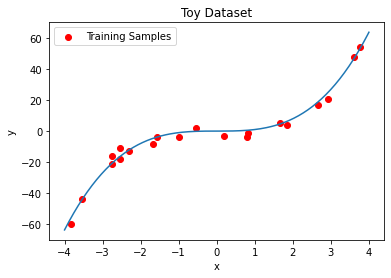

In [3]:
np.random.seed(42)

def draw_examples(n):
    x = np.random.uniform(-4,4, n)
    eps = np.random.normal(0, 3, n)
    y = np.power(x,3) + eps 
    return(x,y)

toy_dataset = draw_examples(20)
inputs, labels = toy_dataset

xs = np.linspace(-4,4,200)
ys = np.power(xs,3)
plt.plot(xs,ys)
plt.scatter(toy_dataset[0],toy_dataset[1], color='r', label='Training Samples')
plt.legend(loc='best')
plt.ylabel("y")
plt.xlabel("x")
plt.title("Toy Dataset")
plt.show()

This exercise is useful for two main reasons. First, since we know the underlying distribution that generated the toy dataset, we are able to easily gauge the accuracy of the predictions and  variance estimates. We would expect the variance estimates to be larger when predicting inputs from outside the scope of the training space. Second, the single dimensionality of this dataset enables us to easily visualize both the accuracy of the predictions and the uncertainty estimates generated. 

We follow the model architectures used in the 2 papers cited earlier very closely so that we are able to compare our graphs with those of these papers. For both the single neural net models and the Deep Ensemble models, we use:
1. A single layer with 100 hidden units and a ReLU activation function
2. ADAM optimizer with learning rate of 0.1
3. 40 epochs for training
4. 5 independently trained neural nets, when using ensembles


#### Single Neural Net


Below, we implement a single neural net with the architecture specified above to fit the toy dataset. We then graph the function $y = x^3$, the 20 training samples, and the predictions from the Neural Net between x = -6 to x = 6. 


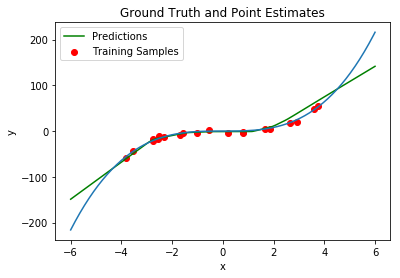

In [18]:
# Setup
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(1, 100)
        self.l2 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

# Create single net with Adam Optimizer 
net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)

running_loss = []
for epoch in range(40):
    epoch_loss = 0
    for x, y in zip(inputs, labels):
        
        x = torch.tensor([x], dtype = torch.float)
        y = torch.tensor([y], dtype = torch.float)
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    running_loss.append(epoch_loss/len(inputs))

xs = np.linspace(-6,6,200)
outputs = [net(torch.tensor([x])) for x in xs]
outputs = np.hstack(torch.stack(outputs).detach().numpy())
plot_point_results(toy_dataset, outputs)

There are 2 important takeaways from looking at this graph.  First, the model performs extremely well when predicting at values for which it has data. In this case, this is between points $x \in [-4, 4]$. However, the model does much worse at the points it does not have data - between $x \in [-6, -4) \cup (4, 6]$. Second, the model fails to output any confidence interval/metric to ascertain how confident we are of any particular prediction. While in this case, we know what the underlying distribution is and can gauge easily how far off our predictions are from the true value on samples outside the training data, on real datasets we do not know this true value and will want uncertainty estimates on our predictions (functionally confidence intervals).


#### Ensembles of Neural Nets


Next, we perform the most basic method of uncertainty estimation, which involves training multiple neural nets independently and then estimating uncertainty by using the empirical variance of the estimates. More specifically, we train 5 neural nets on the toy dataset with the same architecture as above. Then, we combine the predictions as:

$$ \mu_*(\mathbf{x}) = M^{-1} \sum_m \mu_{\theta_m}(\mathbf{x})$$
$$ \sigma_*^2(\mathbf{x}) = M^{-1}\sum_m(\mu_{\theta_m}(\mathbf{x}) - \overline{\mu}_{\theta_m}(\mathbf{x}))^2$$

As above, we graph the underlying curve and the training samples. We then overlay the predictions with a 3 standard deviation envelope, using the empirical variance. This 3 standard deviation envelope can be thought of as a confidence interval for our mean estimates.


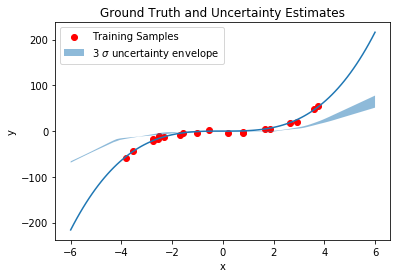

In [26]:
# Net Setup
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(1, 100)
        self.l2 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x
    
criterion = nn.MSELoss()

# Create 5 nets with Adam optimizer
n = 5
nets_ops = []
for i in range(n):
    net = Net()
    optimizer = optim.Adam(net.parameters(), lr=0.1)
    nets_ops.append((net, optimizer))
    
# Train each net
def train_model(net, optimizer):
    running_loss = []
    for epoch in range(40):
        epoch_loss = 0
        for x, y in zip(inputs, labels):

            x = torch.tensor([x], dtype = torch.float)
            y = torch.tensor([y], dtype = torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        running_loss.append(epoch_loss/len(inputs))
        
    xs = np.linspace(-4, 4, 100)
    outputs = [net(torch.tensor([x])) for x in xs]
    outputs = np.hstack(torch.stack(outputs).detach().numpy())
    
    return (running_loss, outputs)



outputs = []
for net, op in nets_ops:
    loss, output = train_model(net, op)
    outputs.append(output)
    
outputs = np.vstack(outputs)
ys = np.mean(outputs, axis = 0)
stds = np.std(outputs, axis = 0)*3

plot_results(toy_dataset, ys, stds)

Interestingly, simple ensembles using empirical variance perform relatively poorly at predicting both the target means and uncertainty estimates. Not only do the predictions of y inaccurately follow the curve, but the 3 standard deviation confidence intervals do not follow the trend we expect them to. As mentioned earlier, we expect the intervals to get wider on unseen data around the edges of this graph (x values of -6 to -4 and 4 to 6) and narrower on x values in the training data (-4 to 4). This is notably not the case with narrow intervals in the left half of the graph, even where the predictions are far away from the true ys.


#### Single Neural Net + Proper Scoring Rule


We now train our data on the proper scoring rule, as proposed by the paper. While the standard neural net has a single output (the prediction) and uses a Mean Squared Error (MSE) criterion, this model will have two outputs in the final layer: the mean prediction and a variance estimate, making it a probabilistic neural net. The proper scoring rule used in the paper assumes the observation is a sample generated from a (heteroscedastic) Gaussian distribution, and it minimizes the Negative Log-Likelihood (NLL) criterion: 
$$ -logp_{\theta}(y_n \bigm| \mathbf{x}_n) = \frac{log(\sigma^2_{\theta}(\mathbf{x}))}{2} + \frac{(y - \mu_{\theta}(\mathbf{x}))^2}{2\sigma^2_{\theta}(\mathbf{x})}$$



This criterion forces our model to optimize for both the accuracy of its prediction and its uncertainty estimates. To understand how the function achieves this, consider the edge cases. If our prediction is completely accurate, $y =  \mu_\theta(\mathbf{x})$, rendering the right term 0 and so this function will minimize the variance estimate, $\sigma^2_{\theta}$. If our prediction is very inaccurate, $|y - \mu_\theta(\mathbf{x})| >> 0$, so the second term in the equation causes the loss criterion to make $\sigma^2_{\theta}$ larger. This optimization makes intuitive sense because we want to predict a low variance (conveying high confidence) when our prediction is accurate and predict a high variance (conveying low confidence) when our prediction is inaccurate.

We use the same architecture as in the single neural net, but change our loss function to this  NLL proper scoring rule. To enforce the constraint that the variance output must be positive, we pass it through the Softplus function and add a minimum variance of $10^{-6}$, as was done in Lakshminarayan et al. (2017). We then train our model on the 20 training examples and graph the predicted target means with a 3 standard deviation envelope, using the predicted variances. We overlay this graph on the plot of $y = x^3$ and the training samples. 


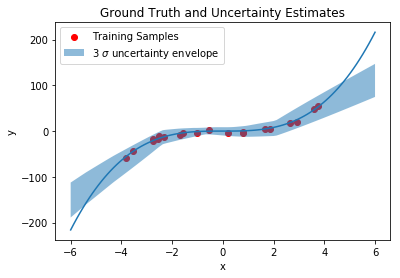

In [30]:
# Net Setup
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(1, 100)
        self.l2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.1)

# Proper scoring rule using negative log likelihood scoring rule
nll_criterion = lambda mu, sigma, y: torch.log(sigma)/2 + ((y-mu)**2)/(2*sigma)
sp = torch.nn.Softplus()


running_loss = []
for epoch in range(40):
    epoch_loss = 0
    for x, y in zip(inputs, labels):
        
        x = torch.tensor([x], dtype = torch.float)
        y = torch.tensor([y], dtype = torch.float)
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(x)
        mu, sig = output[0], sp(output[1])+(10)**-6
        loss = nll_criterion(mu, sig, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    running_loss.append(epoch_loss/len(inputs))

xs = np.linspace(-6, 6, 100)
mu_outputs = [net(torch.tensor([x]))[0] for x in xs]
mu_outputs = np.hstack(torch.stack(mu_outputs).detach().numpy())
sig_outputs = [net(torch.tensor([x]))[1] for x in xs]
sig_outputs = np.sqrt(np.hstack(torch.stack(sig_outputs).detach().numpy()))*3
plot_results(toy_dataset, mu_outputs, sig_outputs)


Comparing this graph to the one from the Ensemble method, we are able to see a significant improvement in uncertainty estimation using the proper scoring rule. As we would hope, the confidence interval of our estimates is much narrower at x values included in the training data (between -4 and 4), and much wider at x values not seen before (-6 to -4 and 4 to 6). While this is certainly an improvement, the difference in the the width of these intervals between seen and unseen x values is not as large as we might want it to be. 


#### Single Neural Net + Proper Scoring Rule + Adversarial Training


Next, we tack on the method of *adversarial* training to our training process. Adversarial training involves modifying the training inputs slightly so as to be visually indistinguishable from the training examples but modified in such a way as to make the model worse at predicting their associated labels. Training using these adversarial examples makes the model more robust since it learns even more on points where it would perform badly. Additionally, adversarial training helps smooth the predictive distribution because it increases the likelihood of the model predicting the training value in an $\epsilon$ region around the training point. Generating adversarial examples involves moving the inputs approximately in the direction of steepest ascent. 

In our particular case, we use the fast gradient sign method to create adversarial examples. This entails creating a new 
$$x’ = x + \epsilon\ \text{sign}(\nabla_x \ell(\theta, x,y))$$

Where $\epsilon = .01\ range(x)$ and evaluating $range(x)$ as the range of the training data along each dimension. We then train the model on both $x$ and $x’$ as two separate data points. The performance of the model is below. It appears to improve performance slightly, but is not too significant. 


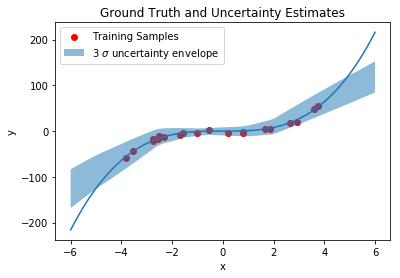

In [31]:
# Net Setup

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(1, 100)
        self.l2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.1)

# Proper scoring rule using negative log likelihood scoring rule

nll_criterion = lambda mu, sigma, y: torch.log(sigma)/2 + ((y-mu)**2)/(2*sigma)
sp = torch.nn.Softplus()

eps = .01*8
running_loss = []
for epoch in range(40):
    epoch_loss = 0
    for x, y in zip(inputs, labels):
        
        x = torch.tensor([x], dtype = torch.float, requires_grad=True)
        y = torch.tensor([y], dtype = torch.float)
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(x)
        mu, sig = output[0], sp(output[1])+(10)**-6
        loss = nll_criterion(mu, sig, y)
        loss.backward(retain_graph=True)

        # Calculate x' as described in paper
        x_a = x + eps*(torch.sign(x.grad.data))
        optimizer.zero_grad()
        
        output_a = net(x_a)
        mu_a, sig_a = output_a[0], sp(output_a[1])+(10)**-6

        # Compute loss as sum of l(x) + l(x')
        loss = nll_criterion(mu, sig, y) + nll_criterion(mu_a, sig_a, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        
    running_loss.append(epoch_loss/len(inputs))

xs = np.linspace(-6, 6, 100)
mu_outputs = [net(torch.tensor([x]))[0] for x in xs]
mu_outputs = np.hstack(torch.stack(mu_outputs).detach().numpy())
sig_outputs = [net(torch.tensor([x]))[1] for x in xs]
sig_outputs = np.sqrt(np.hstack(torch.stack(sig_outputs).detach().numpy()))*3
plot_results(toy_dataset, mu_outputs, sig_outputs)

#### Ensemble + Proper Scoring Rule + Adversarial Training


Finally, the big reveal. We combine all of the methods described above, and train 5 independent probabilistic neural nets using the proper scoring rule and adversarial training. Then, we combine their predictions as an ensemble. Since each neural net now has two outputs (unlike in the original ensemble case), we need a more nuanced method of combining the resulting predictions. This method is to set
$$ \mu_{*}(\mathbf{x}) = M^{-1}\sum_m\mu_{\theta_m}(\mathbf{x})$$
$$\sigma_{*}^2 = M^{-1}\sum_m(\sigma{\theta_m}^2(\mathbf{x}) + \mu_{\theta_m}(\mathbf{x})) - \mu_{*}^2(\mathbf{x})$$

where M is the number of neural nets in the ensemble. We can implement this method on the toy dataset and plot the results:





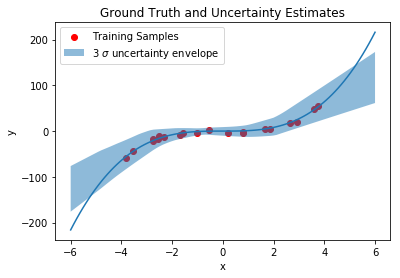

In [32]:
# Net Setup

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(1, 100)
        self.l2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

# Proper scoring rule using negative log likelihood scoring rule
nll_criterion = lambda mu, sigma, y: torch.log(sigma)/2 + ((y-mu)**2)/(2*sigma)
sp = torch.nn.Softplus()

# Create 5 neural nets with identical implementations
n = 5
nets_ops = []
for i in range(n):
    net = Net()
    optimizer = optim.Adam(net.parameters(), lr=0.1)
    nets_ops.append((net, optimizer))

# Train 
def train_model(net, optimizer):
    eps = .01*8
    alpha = .5
    running_loss = []
    for epoch in range(40):
        epoch_loss = 0
        for x, y in zip(inputs, labels):

            x = torch.tensor([x], dtype = torch.float, requires_grad=True)
            y = torch.tensor([y], dtype = torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(x)
            mu, sig = output[0], sp(output[1])+(10)**-6
            loss = nll_criterion(mu, sig, y)
            loss.backward(retain_graph=True)

            x_a = x + eps*(torch.sign(x.grad.data))
            optimizer.zero_grad()

            output_a = net(x_a)
            mu_a, sig_a = output_a[0], sp(output_a[1])+(10)**-6

            loss = alpha*nll_criterion(mu, sig, y) + (1-alpha)*nll_criterion(mu_a, sig_a, y)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()

        running_loss.append(epoch_loss/len(inputs))

    xs = np.linspace(-6, 6, 100)
    mu_outputs = [net(torch.tensor([x]))[0] for x in xs]
    mu_outputs = np.hstack(torch.stack(mu_outputs).detach().numpy())
    sig_outputs = [net(torch.tensor([x]))[1] for x in xs]
    sig_outputs = np.hstack(torch.stack(sig_outputs).detach().numpy())
    return(running_loss, mu_outputs, sig_outputs)

# Generate predictions for each net
mus = []
sigs = []
for net, op in nets_ops:
    loss, mu, sig = train_model(net, op)
    mus.append(mu)
    sigs.append(sig)

# Combine the outputs using the criteria explained above
mus = np.vstack(mus)
mu_stars = np.mean(mus, axis = 0)
sigs = np.vstack(sigs)

var_stars = np.mean(np.power(mus, 2) + sigs, axis = 0) - np.power(mu_stars, 2)
sig_3 = np.sqrt(var_stars)*3
plot_results(toy_dataset, mu_stars, sig_3)





The resulting confidence intervals here are remarkable. Within the scope of the training data, the confidence intervals are quite narrow and fit the data well. Outside the training data, the confidence intervals continue to fit the underlying line fairly well, and the intervals get very wide. This model is by far the best performing model among those trained on the toy data set, validating the results of the paper. 



#### Comparison with Lakshminaryanan et al. (2017)


Our models perform equivalently to those of Lakshminaryanan et al. (2017).



![title](https://www.dropbox.com/s/6vcqdknaz1oapk1/Final%20Plots.png?dl=1)

Figure 1: Results on a toy regression task: x-axis denotes x. On the y-axis, the blue line is the ground truth curve, the red dots are observed noisy training data points and the gray/blue shadows correspond to the predicted mean along with three standard deviations. The top row are the results of Lakshminarayanan et al. (2017) and the bottom row are results from this tutorial. Left most plot corresponds to empirical variance of 5 networks trained using MSE, second plot shows the effect of training using NLL using a single net, third plot shows the additional effect of adversarial training, and final plot shows the effect of using an ensemble of 5 networks respectively.

### Exploring Applications to Real World Data through the Boston Housing Dataset 


#### Boston Housing Dataset


The Boston Housing Dataset, accessed easily through the scikit learn module, provides data from the US Census Service regarding housing in and around Boston, Massachusetts. 

The data has 506 observations, which is an order of magnitude larger than our Toy Dataset but not so large as to be computationally challenging. With 13 features that capture various aspects of homes and location (e.g., per capita crime rate), we aim to predict MEDV - Median value of owner-occupied homes in thousands. 

#### Implementation

We follow the model architectures used in Lakshminarayanan et al. (2017) cited earlier very closely so that we are able to compare our results with those of the paper. 

In our model, we use the following architecture and specifications:
1. A single layer with 100 hidden units and a ReLU activation function
2. ADAM optimizer with learning rate of 0.1
3. Train for 40 epochs
4. 5 neural nets in the ensemble
5. Adversarial training 
6. Each model is trained on a random subset of 90% of the data set and tested on 10%. This process is repeated 5 times.


In [37]:
from sklearn.datasets import load_boston
import torch.utils.data
boston = load_boston()


features = torch.from_numpy(np.array(boston.data)).float()  # convert the numpy array into torch tensor
labels = torch.from_numpy(np.array(boston.target)).float()

# Create the net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(13, 50)
        self.l2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.1)
nll_criterion = lambda mu, sigma, y: torch.log(sigma)/2 + ((y-mu)**2)/(2*sigma)

# Eval functions used to compute final loss
nll_eval = lambda mu, sigma, y: np.log(sigma)/2 + ((y-mu)**2)/(2*sigma)
mse_eval = lambda mu, y: np.sqrt(np.mean(np.power(mu-y,2)))
sp = torch.nn.Softplus()

# Normalize the data
normed_features = (features - torch.mean(features, 0))/(torch.std(features,0))
normed_features[:, 3] = features[:, 3] # Don't normalize binary value
full_dataset = torch.cat((normed_features, labels.view(-1,1)), 1)


train_size = int(0.9 * len(features))
test_size = len(features) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

def get_split():
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    return (train_dataset[:,], test_dataset[:,])
    
    
eps = .01*8
split_nlls = []
split_mses = []

for split in range(5):

    train, test = get_split()
    
    # Test points that we'll use each net to evaluate
    test_inputs = test[:, :13]
    test_labels = test[:, 13]
    mus_ensemble  = []
    sigs_ensemble = []
    
    
    for i in range(5):
        net = Net()
        optimizer = optim.Adam(net.parameters(), lr=0.1)
        running_loss = []    
        for epoch in range(40):
            # Randomly shuffle train
            train = train[torch.randperm(len(train)), :]
            
            inputs = train[:, :13]
            labels = train[:, 13]
            
            epoch_loss = 0

            for x, y in zip(inputs, labels):

                x = torch.tensor(x, dtype = torch.float, requires_grad=True)
                y = torch.tensor([y], dtype = torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output = net(x)
                mu, sig = output[0], sp(output[1])+(10)**-6
                loss = nll_criterion(mu, sig, y)                
                loss.backward(retain_graph=True)

                x_a = x + eps*(torch.sign(x.grad.data))
                optimizer.zero_grad()

                output_a = net(x_a)
                mu_a, sig_a = output_a[0], sp(output_a[1])+(10)**-6

                loss = nll_criterion(mu, sig, y) + nll_criterion(mu_a, sig_a, y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
            running_loss.append(epoch_loss/len(inputs))

      
        mus, sigs = [], []
        for x in test_inputs:
            x = torch.tensor(x, dtype = torch.float, requires_grad=True)
            output = net(x)
            mu, sig = output[0], sp(output[1])+(10)**-6
            mus.append(mu)
            sigs.append(sig)
        mus = np.hstack(torch.stack(mus).detach().numpy())
        sigs = np.sqrt(np.hstack(torch.stack(sigs).detach().numpy()))
        
        # Storing the predictions from each neural net
        mus_ensemble.append(mus)
        sigs_ensemble.append(sigs)

            
    # Combine the predictions from each net into mu_star, sigma_star
    mus_stack = np.vstack(mus_ensemble)
    mu_stars = np.mean(mus_stack, axis = 0)
    sigs_stack = np.vstack(sigs_ensemble)
    sig_stars = np.mean(np.power(mus_stack, 2) + sigs_stack, axis = 0) - np.power(mu_stars, 2)
    y = test_labels.numpy()

    # Now have mu and variances as numpy arrays
    # have to converrt back to tensor to plug them into the criterions
    # Better to just have numpy mse and nll functions
    nll_loss = nll_eval(mu_stars, sig_stars, y)
    mse_loss = mse_eval(mu_stars, y)
    
    split_nlls.append(nll_loss)
    split_mses.append(mse_loss)

# Finally, take the average NLL and MSE acrross folds
nll = np.mean(split_nlls)
nll_std = np.std(split_nlls)
mse = np.mean(split_mses)
mse_std = np.std(split_mses)

### References

1. Lakshminarayanan, Balaji, Alexander Pritzel, and Charles Blundell. "Simple and scalable predictive uncertainty estimation using deep ensembles." Advances in Neural Information Processing Systems. 2017.
2. Hernández-Lobato, José Miguel, and Ryan Adams. "Probabilistic backpropagation for scalable learning of bayesian neural networks." International Conference on Machine Learning. 2015.
3. Gal, Yarin, and Zoubin Ghahramani. "Dropout as a Bayesian approximation: Representing model uncertainty in deep learning." international conference on machine learning. 2016.